<a href="https://colab.research.google.com/github/AlessLG/practicas_curvas-de-rotacion/blob/main/ajustes_curvas_rotacion_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import os

# G = 4.3e-3 # pc • (km/s)² / M_⊙
G = 4.3e-6 # kpc • (km/s)² / M_⊙

descargar_figuras = False

def v_Hernquist(r, M, a):
    return np.sqrt(G*M*r/(a+r)**2)

def v_plummer(r, M, a):
    return np.sqrt(G*M/(r*(1+a**2/r**2)**(3/2)))

def v_nfw(r, A, r_s):
    return np.sqrt((4*np.pi*G*A)*((1/r)*np.log(1+r/r_s)-1/(r_s+r)))

def v_sol_reparam(r, rho_c, a):
    B = rho_c * (a**16)
    return v_sol(r, B, a)

def v_sol(r, B, a, G=4.3e-6):
    r_safe = np.where(r == 0, 1e-9, r)
    poly_part = (
        -0.177069 * a**13 * r_safe
        + 0.225911 * a**11 * r_safe**3
        + 0.039069 * a**9 * r_safe**5
        + 0.0039039 * a**7 * r_safe**7
        + 0.000229089 * a**5 * r_safe**9
        + 7.36645e-6 * a**3 * r_safe**11
        + 1.00552e-7 * a * r_safe**13
    )
    arctan_poly_part = (
        0.586978 * a**14
        + 0.373905 * a**12 * r_safe**2
        + 0.102076 * a**10 * r_safe**4
        + 0.0154815 * a**8 * r_safe**6
        + 0.00140882 * a**6 * r_safe**8
        + 7.69216e-5 * a**4 * r_safe**10
        + 2.33329e-6 * a**2 * r_safe**12
        + 3.03327e-8 * r_safe**14
    )
    arctan_term = arctan_poly_part * np.arctan(0.301662 * r_safe / a)
    numerator_content = B * G * (poly_part + arctan_term)
    denominator = a**13 * r_safe * (a**2 + 0.091 * r_safe**2)**7
    term_inside_sqrt = np.maximum(0, (4 * np.pi * numerator_content) / denominator)
    velocity = np.sqrt(term_inside_sqrt)
    if np.isscalar(r):
        if r == 0: return 0.0
    else:
        velocity[r == 0] = 0.0
    return velocity

In [34]:
def fit_and_plot_rotation_curve(file_path, show_plot=True, save_plot_path=None):
    """
    Carga datos de una curva de rotación, ajusta 4 modelos de halo,
    imprime los resultados y genera gráficos de ajuste y residuos.
    """

    # --- 1. Carga de Datos ---
    try:
        data = np.genfromtxt(file_path, delimiter='\t')
        r_data, v_data, err_data = data[:, 0], data[:, 1], data[:, 2]
    except (IOError, IndexError) as e:
        print(f"Error al procesar el archivo '{file_path}': {e}")
        return None

    # --- 2. Preparación de Modelos y Ajuste ---
    ### NUEVO ###: Mover la configuración de modelos aquí dentro.
    model_config = {
        "Hernquist": {"func": v_Hernquist, "x0": [1e11, 10.0], "param_labels": ["Masa", "a"]},
        "Plummer":   {"func": v_plummer, "x0": [1e11, 10.0], "param_labels": ["Masa", "a"]},
        "NFW":       {"func": v_nfw, "x0": [1e11, 10.0], "param_labels": ["A", "r_s"]},
        "Solitón":   {"func": v_sol_reparam, "x0": [1e7, 10.0], "param_labels": ["ρ_c", "a"]},
    }

    resultados = {}

    def residuals(params, func, r, v_obs, v_err):
        return (func(r, *params) - v_obs) / v_err

    for name, config in model_config.items():
        res = least_squares(residuals, config["x0"], args=(config["func"], r_data, v_data, err_data), bounds=([0, 0], [np.inf, np.inf]))
        params, J = res.x, res.jac
        try:
            errors = np.sqrt(np.diag(np.linalg.inv(J.T @ J)))
        except np.linalg.LinAlgError:
            errors = [np.inf, np.inf]

        dof = len(v_data) - len(params)
        chi2_red = np.sum(res.fun**2) / dof if dof > 0 else np.inf
        resultados[name] = {"params": params, "errors": errors, "chi2_red": chi2_red}

    # --- 3. Impresión de Resultados ---
    galaxy_name = os.path.basename(file_path).split('_')[0]
    print(f"\n--- Resultados de Ajustes para la Galaxia: {galaxy_name} ---")
    for name, res in sorted(resultados.items(), key=lambda item: item[1]['chi2_red']):
        p1, p2 = res['params']
        e1, e2 = res['errors']
        l1, l2 = model_config[name]["param_labels"]
        unit = "M⊙/kpc³" if name == "Solitón" else "M⊙"

        print(f"{name}: (χ²_red = {res['chi2_red']:.3f})")
        print(f"  {l1:<5} = ({p1:.2e} ± {e1:.1e}) {unit}")
        print(f"  {l2:<5} = ({p2:.2f} ± {e2:.2f}) kpc")
        print("-" * 45)

    # --- 4. Generación del Gráfico de Ajuste ---
    if not (show_plot or save_plot_path):
        return resultados

    colors = {'Plummer': 'g', 'Solitón': 'k', 'Hernquist': 'b', 'NFW': 'r'}
    styles = {'Plummer': '-', 'Solitón': ':', 'Hernquist': '--', 'NFW': '-.'}
    markers = {'Plummer': 'o', 'Solitón': 's', 'Hernquist': '^', 'NFW': 'D'}

    plt.figure(figsize=(6, 4))
    d = np.linspace(0, r_data.max(), 200)

    plt.errorbar(r_data, v_data, yerr=err_data, fmt='o', color='black', label='Datos SPARC', capsize=4, markersize=5)

    for name, res in resultados.items():
        plt.plot(d, model_config[name]["func"](d, *res['params']),
                 color=colors[name], linestyle=styles[name],
                 label=f'{name} (χ²_red={res["chi2_red"]:.2f})')

    plt.xlabel('Radio (kpc)')
    plt.ylabel('Velocidad (km/s)')
    plt.title(f'Ajuste de Curva de Rotación para {galaxy_name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0)
    plt.ylim(0)

    if save_plot_path:
        plt.savefig(f"{galaxy_name}_fit.png", dpi=300, bbox_inches='tight')

    if show_plot:
        plt.show()
    plt.close()

    # --- 5. Gráfico de Mariposa Unificado ---
    plt.figure(figsize=(6, 3))
    # plt.fill_between(r_data, -err_data, err_data, color='gray', alpha=0.3, label='Incertidumbre (±1σ)')
    plt.axhline(0, linestyle='--', color='black', linewidth=1.5)

    for name in model_config.keys():
        v_model = model_config[name]["func"](r_data, *resultados[name]['params'])
        plt.plot(r_data, v_data - v_model,
                 marker=markers[name],
                 linestyle='None',
                 color=colors[name],
                 markersize=7,
                 alpha=0.8,
                 label=f'{name} (χ²_red={resultados[name]["chi2_red"]:.2f})')

    plt.title(f'Residuos de ({galaxy_name})')
    plt.xlabel('Radio (kpc)')
    plt.ylabel('Residuo (km/s)')
    plt.tick_params(direction='in', top=True, right=True)
    # plt.legend(ncol=2)
    plt.grid(True, linestyle=':', alpha=0.7)
    # plt.xlim(0, r_data.max())

    max_residual_abs = np.max([np.abs(v_data - model_config[name]["func"](r_data, *resultados[name]['params'])) for name in model_config.keys()])
    max_err = np.max(err_data)
    plt.ylim(-max(max_residual_abs, max_err) * 1.5, max(max_residual_abs, max_err) * 1.5)

    if save_plot_path:
        plt.savefig(f"{galaxy_name}_residuals.pdf", bbox_inches='tight')

    if show_plot:
        plt.show()
    plt.close()

    return resultados


--- Resultados de Ajustes para la Galaxia: F563-1 ---
Plummer: (χ²_red = 0.918)
  Masa  = (5.47e+10 ± 5.3e+09) M⊙
  a     = (6.99 ± 0.52) kpc
---------------------------------------------
Hernquist: (χ²_red = 1.048)
  Masa  = (3.76e+11 ± 1.4e+11) M⊙
  a     = (30.10 ± 7.70) kpc
---------------------------------------------
NFW: (χ²_red = 1.068)
  A     = (2.22e+10 ± 9.4e+09) M⊙
  r_s   = (18.21 ± 5.16) kpc
---------------------------------------------
Solitón: (χ²_red = 1.556)
  ρ_c   = (3.25e+07 ± 4.8e+06) M⊙/kpc³
  a     = (4.80 ± 0.31) kpc
---------------------------------------------


/tmp/ipython-input-880962902.py:15: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(G*M/(r*(1+a**2/r**2)**(3/2)))
/tmp/ipython-input-880962902.py:15: RuntimeWarning: invalid value encountered in multiply
  return np.sqrt(G*M/(r*(1+a**2/r**2)**(3/2)))
/tmp/ipython-input-880962902.py:18: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt((4*np.pi*G*A)*((1/r)*np.log(1+r/r_s)-1/(r_s+r)))
/tmp/ipython-input-880962902.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.sqrt((4*np.pi*G*A)*((1/r)*np.log(1+r/r_s)-1/(r_s+r)))


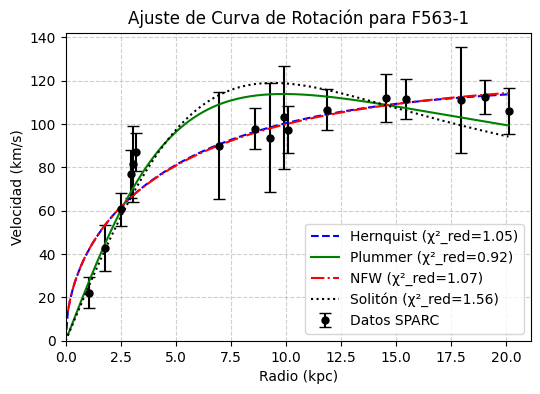

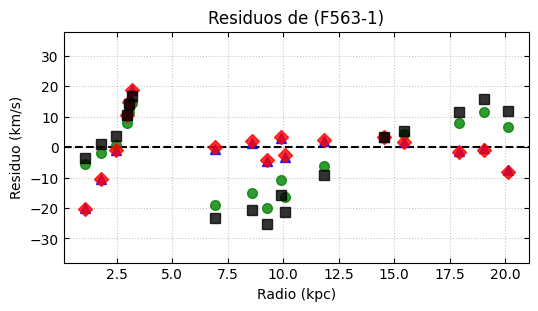

In [35]:
# Lista de archivos de galaxias que quieres analizar
galaxy_files = [
    '/content/F563-1_rotmod.dat'
    # ,
    # '/content/F563-V2_rotmod.dat',
    # '/content/F568-1_rotmod.dat',
    # '/content/F568-3_rotmod.dat'
]

# Un diccionario para guardar todos los resultados si los necesitas después
resultados = {}

# Itera sobre cada archivo, realiza el análisis completo y muestra los resultados
for file in galaxy_files:
    galaxy_name = os.path.basename(file).split('_')[0]

    # Llama a la función. Ella se encarga de todo.
    # También le decimos que guarde el gráfico en un archivo PNG con el nombre de la galaxia.
    results = fit_and_plot_rotation_curve(
        file_path=file,
        show_plot=True,
        save_plot_path=False
        # save_plot_path=f"{galaxy_name}_fit.pdf"
    )

    if results:
        resultados[galaxy_name] = results